# Naive Bayes Sınıflandırma

Naive Bayes sınıflandırma, olasılık temelli bir makine öğrenmesi algoritmasıdır.
Naive Bayes algoritması, sınıfların olasılıklarını Bayes Teoremi ile hesaplar:

## Bayes Sınıflandırıcı

- Sürekli (sayısal) veriler doğrudan sayılmaz(tekrar edilme olasılığı çok az olduğu için) bu yüzden verileri kategorik hale cevirmeliyiz
- Aşağıdaki formüle göre karar verir. Bu çerçevede özelliklerin bağımlı veya bağımsız olup olmaması önemli değildir. 
- Tüm olasılık dağılımlarını doğru şekilde modellenmeye çalışılır.
- Veri kümesindeki tüm özelliklerin ve sınıfların olasılık dağılımlarını eksiksiz ve doğru bir şekilde öğrenmeye çalışır.

![bayes_formul](images/bayes_formul.png)

![bayes_formul](images/bayes_formul_aciklama.png)

In [61]:
import pandas as pd

# Veriyi oku ve hedef değişkeni oluştur
df = pd.read_csv("data.csv")
df['gercek'] = df['exam_score'].apply(lambda x: 'Geçti' if x >= 60 else 'Kaldı')

# Sürekli değişkenleri kategorik hale getiriyoruz
df['study_cat'] = pd.cut(df['study_hours_per_day'], bins=3, labels=["low", "medium", "high"])
df['attendance_cat'] = pd.cut(df['attendance_percentage'], bins=3, labels=["low", "medium", "high"])

# Koşullu olasılıkları öğrenmek için gruplama
prob_table = df.groupby(['study_cat', 'attendance_cat', 'gercek'], observed=False).size().reset_index(name='count')

# Sınıf ön olasılıkları
class_counts = df['gercek'].value_counts()
total = len(df)

# Bayes sınıflayıcı fonksiyonu
def predict_bayes_with_probs(row, prob_table, class_counts, total):
    results = {}
    for cls in class_counts.index:
        P_C = class_counts[cls] / total
        match = prob_table[
            (prob_table['study_cat'] == row['study_cat']) &
            (prob_table['attendance_cat'] == row['attendance_cat']) &
            (prob_table['gercek'] == cls)
        ]
        if not match.empty:
            P_X_given_C = match.iloc[0]['count'] / class_counts[cls]
        else:
            P_X_given_C = 1e-6
        results[cls] = P_X_given_C * P_C
    
    total_prob = sum(results.values())
    probs = {cls: results[cls] / total_prob for cls in results}
    predicted_class = max(probs, key=probs.get)
    return predicted_class, probs['Geçti'], probs['Kaldı']

# Tüm satırlar için tahmin
df[['tahmin', 'P_Geçti', 'P_Kaldı']] = df.apply(
    lambda row: pd.Series(predict_bayes_with_probs(row, prob_table, class_counts, total)),
    axis=1
)

# Doğruluk oranı
accuracy = (df['gercek'] == df['tahmin']).mean()
print(f"\n✅ Doğruluk Oranı: {accuracy:.2f}\n")

# Toplam doğru tahmin sayısı
true_count = (df['gercek'] == df['tahmin']).sum()
print(f"✅ Başarılı Tahmin Sayısı: {true_count} / {len(df)}")

# Tüm tahminleri yazdır (renkli: yanlış tahmin = kırmızı)
print("\n📋 Tüm Satırlar İçin Tahmin ve Olasılıklar:")
for i, row in df.iterrows():
    g = row['gercek']
    t = row['tahmin']
    pg = row['P_Geçti']
    pk = row['P_Kaldı']
    
    if g != t:
        # 🔴 Kırmızı renk kodu: \033[91m
        print(f"\033[91mSatır {i}: Gerçek = {g}, Tahmin = {t}, P(Geçti) = {pg:.4f}, P(Kaldı) = {pk:.4f}\033[0m")
    else:
        print(f"Satır {i}: Gerçek = {g}, Tahmin = {t}, P(Geçti) = {pg:.4f}, P(Kaldı) = {pk:.4f}")


# En yüksek P(Geçti)
max_gecti_row = df.loc[df['P_Geçti'].idxmax()]
print("\n⭐ En Yüksek P(Geçti) Olasılığı:")
print(f"Gerçek = {max_gecti_row['gercek']}, Tahmin = {max_gecti_row['tahmin']}, "
      f"P(Geçti) = {max_gecti_row['P_Geçti']:.4f}, P(Kaldı) = {max_gecti_row['P_Kaldı']:.4f}")

# En yüksek P(Kaldı)
max_kaldi_row = df.loc[df['P_Kaldı'].idxmax()]
print("\n⭐ En Yüksek P(Kaldı) Olasılığı:")
print(f"Gerçek = {max_kaldi_row['gercek']}, Tahmin = {max_kaldi_row['tahmin']}, "
      f"P(Geçti) = {max_kaldi_row['P_Geçti']:.4f}, P(Kaldı) = {max_kaldi_row['P_Kaldı']:.4f}")



✅ Doğruluk Oranı: 0.85

✅ Başarılı Tahmin Sayısı: 851 / 1000

📋 Tüm Satırlar İçin Tahmin ve Olasılıklar:
Satır 0: Gerçek = Kaldı, Tahmin = Kaldı, P(Geçti) = 0.2552, P(Kaldı) = 0.7448
Satır 1: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 1.0000, P(Kaldı) = 0.0000
Satır 2: Gerçek = Kaldı, Tahmin = Kaldı, P(Geçti) = 0.3053, P(Kaldı) = 0.6947
Satır 3: Gerçek = Kaldı, Tahmin = Kaldı, P(Geçti) = 0.2552, P(Kaldı) = 0.7448
Satır 4: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 0.9124, P(Kaldı) = 0.0876
Satır 5: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 1.0000, P(Kaldı) = 0.0000
Satır 6: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 1.0000, P(Kaldı) = 0.0000
Satır 7: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 0.8838, P(Kaldı) = 0.1162
Satır 8: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 0.9124, P(Kaldı) = 0.0876
Satır 9: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 0.9124, P(Kaldı) = 0.0876
Satır 10: Gerçek = Geçti, Tahmin = Geçti, P(Geçti) = 0.8838, P(Kaldı) = 0.1162
Satır 11: Gerçek = Geçti, Tahmin = 

# Naive Bayes Teoremi
- Naive Bayes, Bayes Teoremi’ne dayalı bir sınıflandırma algoritmasıdır.
- Model, her bir özelliğin (örneğin: çalışma süresi, derse katılım) sınıf üzerinde bağımsız bir etkisi olduğunu varsayar.
Yani bir özelliğin değeri, diğer bir özelliğin değerinden etkilenmez.

x1: çalışma süresi (study_hours)

x2: derse katılım (attendance)

Naive Bayes, bu iki özellik arasında hiçbir ilişki yokmuş gibi davranır.

![Naive_bayes](images/naive_bayes_teoremi.png)

![Naive_bayes_formul](images/naive_bayes_formul.png)


✅ Doğruluk Oranı: 0.94

📊 Sınıflandırma Raporu:

              precision    recall  f1-score   support

       Geçti       0.94      0.97      0.96       149
       Kaldı       0.91      0.82      0.87        51

    accuracy                           0.94       200
   macro avg       0.93      0.90      0.91       200
weighted avg       0.93      0.94      0.93       200



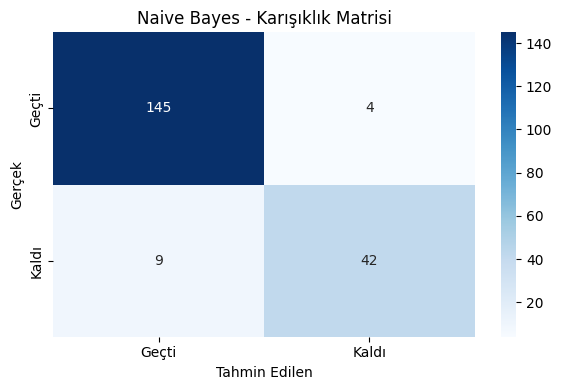

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Veri okuma
df = pd.read_csv("data.csv")
df['result'] = df['exam_score'].apply(lambda x: 'Geçti' if x >= 60 else 'Kaldı')

# Özellik ve hedef değişkenleri ayır
X = df.drop(columns=['student_id', 'grade', 'exam_score', 'result'])
y = df['result']

# Kategorik verileri sayısallaştır
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Modeli eğit
model = GaussianNB()
model.fit(X_train, y_train)

# Tahmin ve olasılıklar
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Sınıf etiketlerini al
class_labels = model.classes_

# Tahmin sonuçlarını DataFrame'e koy
result_df = X_test.copy()
result_df['gercek'] = y_test.values
result_df['tahmin'] = y_pred
result_df['P_Geçti'] = y_proba[:, list(class_labels).index('Geçti')]
result_df['P_Kaldı'] = y_proba[:, list(class_labels).index('Kaldı')]
result_df['max_proba'] = result_df[['P_Geçti', 'P_Kaldı']].max(axis=1)
result_df['min_proba'] = result_df[['P_Geçti', 'P_Kaldı']].min(axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Doğruluk Oranı: {accuracy:.2f}")

# Karışıklık matrisi
print("\n📊 Sınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Naive Bayes - Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.tight_layout()
plt.show()



# Sınıf Bazlı Performans

## Geçti

| Metrik     | Değer | Açıklama                                            |
| --------- | ----- | --------------------------------------------------- |
| Precision | 0.94  | Model "Geçti" dediklerinin %94'ü doğru              |
| Recall    | 0.97  | Gerçek "Geçti" olanların %97’sini doğru tahmin etti |
| F1-Score  | 0.96  | Precision ve recall’un dengesi çok iyi              |
| Support   | 149   | Test setinde 149 öğrenci gerçekten “Geçti”          |

## Kaldı

| Metrik     | Değer | Açıklama                                    |
| --------- | ----- | ------------------------------------------- |
| Precision | 0.91  | Model “Kaldı” dediğinde %91’i doğru         |
| Recall    | 0.82  | Gerçek “Kaldı” olanların %82’sini bulabildi |
| F1-Score  | 0.87  | Denge fena değil, ama biraz recall düşmüş   |
| Support   | 51    | Test setinde 51 öğrenci gerçekten “Kaldı”   |

